In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer
from qiskit.circuit.library import HGate, IGate
import numpy as np
import random

In [2]:
alice = QuantumRegister(4, name="alice")
bob = QuantumRegister(4, name="bob")
out = ClassicalRegister(4, name="out")

In [3]:
sim = Aer.get_backend("aer_simulator")

### Generate random basis

In [4]:
def generate_random_basis(circuit, qubits):
    gates = [HGate(), IGate()]
    for qubit in qubits:
        gate = random.choice(gates)
        circuit.append(gate, [qubit])
    return circuit

### Generate Encoded Input from bit string

In [5]:
def generate_input_from_string(alice_circuit, bit_string):
    for qubit, bit in enumerate(bit_string[::-1]):
        if(bit == '1'):
            alice_circuit.x(qubit)
    return alice_circuit

### Alice Circuit

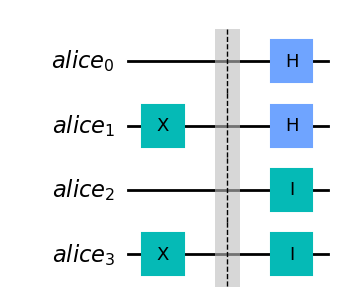

In [6]:
alice_circuit = QuantumCircuit(alice, name="alice")
alice_circuit = generate_input_from_string(alice_circuit, "1010")
alice_circuit.barrier()
alice_circuit = generate_random_basis(alice_circuit, alice)
alice_circuit.draw("mpl")

### Bob circuit

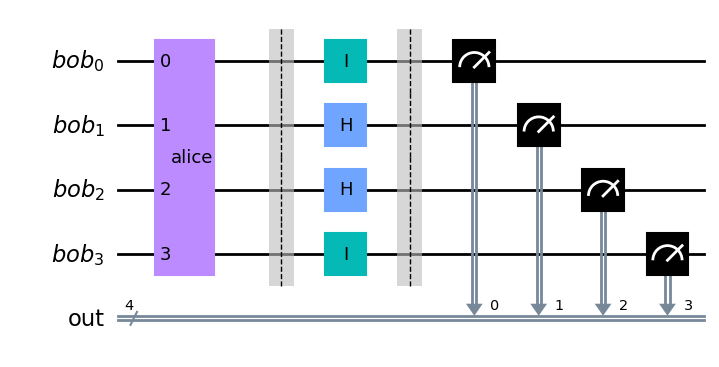

In [100]:
bob_circuit = QuantumCircuit(bob, out)
bob_circuit.append(alice_circuit, bob)
bob_circuit.barrier()
bob_circuit = generate_random_basis(bob_circuit, bob)
bob_circuit.barrier()
bob_circuit.measure(bob, out)
bob_circuit.draw("mpl")

In [104]:
def get_key(qc, sim):
    total_qubits = len(qc.qubits)
    max_states = 2**total_qubits
    
    results = sim.run(qc.decompose(), shots=1024).result().get_counts()
    result_states = list(results.keys())
    
    if(max_states == len(result_states)):
        raise Exception('No key available')
    
    base_state = result_states[0]
    
    if(len(result_states) == 1):
        return base_state
    
    default_char = '-'
    key = [default_char]*total_qubits
    
    for index, bit in enumerate(result_states[1]):
        if(base_state[index] == bit and key[index] == default_char):
            key[index] = bit
        
        if((base_state[index] == bit or base_state[index] != bit) and key[index] != default_char and key[index] != bit):
            key[index] = default_char
            
    
    for state in result_states[2:]:
        for index, bit in enumerate(state):
            if(key[index] != default_char and key[index] != bit):
                key[index] = default_char

    return ''.join(key)

print(get_key(bob_circuit, sim))


1-1-


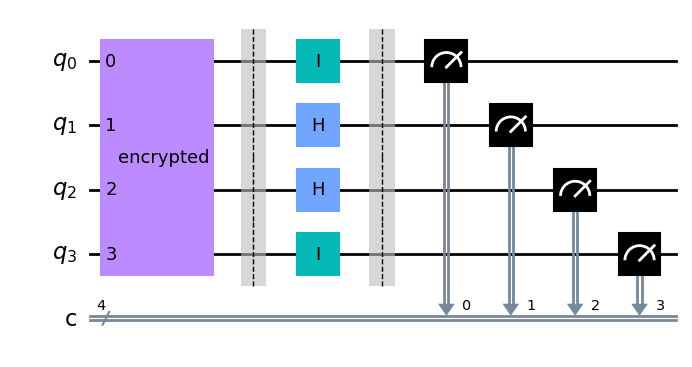

error -->  No key available


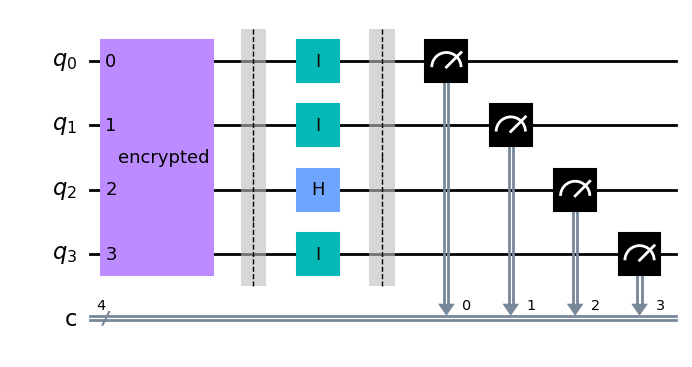

'--0-'

In [140]:
def generate_key(bit_string, qubits=4):
    if(len(bit_string) != qubits):
        raise ValueException('the bit string needs to have the same length as qubits array')
    
    sim = Aer.get_backend("aer_simulator")
    
    bits = qubits
    qubits_iterator = range(qubits)
    bits_iterator = range(bits)
    
    encrypted_info = QuantumCircuit(qubits)
    encrypted_info = generate_input_from_string(encrypted_info, bit_string)
    encrypted_info = generate_random_basis(encrypted_info, qubits_iterator)
    encrypted_info_gate = encrypted_info.to_gate(label="encrypted")
    
    while True:
        try:
            qc = QuantumCircuit(qubits, bits)
            qc.append(encrypted_info_gate, qubits_iterator)
            qc.barrier()
            qc = generate_random_basis(qc, qubits_iterator)
            qc.barrier()
            qc.measure(qubits_iterator, bits_iterator)
            
            display(qc.draw('mpl'))
            return get_key(qc, sim)
        
        except Exception as error:
            print('error --> ', str(error))
    
    
    
generate_key('1100') 

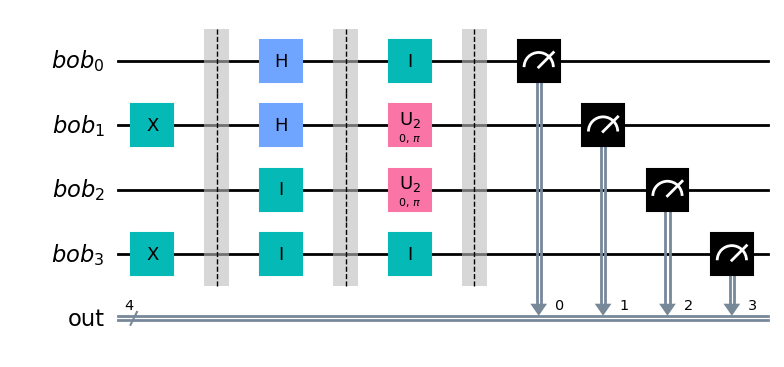

In [142]:
bob_circuit.decompose().draw('mpl')